# Embedded ML - Lab 2.3: TensorFlow Lite

# Luis Fernando Torres

In this lab you will learn the basics of TensorFlow Lite, a complement of TensorFlow that allows you to optimize and run models on constrained devices. It provides a much lighter runtime than TensorFlow but it only supports a subset of the tools available in full TensorFlow.

In this lab you might be given some helper functions but you are expected to write most of the code and be able to explain it at a high level of abstraction and also to modify any part of it.

### Learning outcomes


* Explain the basic concepts associated with TensorFlow Lite
* Develop applications following the basic TensorFlow Lite workflow
* Implement post-training quantization using TensorFlow Lite tools

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from google.colab import drive
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pylab as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import pathlib
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Filter the dataset to include only '0' and '1' digits
train_filter = np.where((y_train == 0) | (y_train == 1))
test_filter = np.where((y_test == 0) | (y_test == 1))

x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]

# Create directories to save the filtered dataset
base_dir = '/content/mnist_binary'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

train_0_dir = os.path.join(train_dir, '0')
train_1_dir = os.path.join(train_dir, '1')
test_0_dir = os.path.join(test_dir, '0')
test_1_dir = os.path.join(test_dir, '1')

os.makedirs(train_0_dir, exist_ok=True)
os.makedirs(train_1_dir, exist_ok=True)
os.makedirs(test_0_dir, exist_ok=True)
os.makedirs(test_1_dir, exist_ok=True)

# Save the filtered dataset as images
from PIL import Image

def save_images(images, labels, base_dir):
    for i, (img, label) in enumerate(zip(images, labels)):
        label_dir = os.path.join(base_dir, str(label))
        img = Image.fromarray(img)
        img.save(os.path.join(label_dir, f'{i}.png'))

save_images(x_train, y_train, train_dir)
save_images(x_test, y_test, test_dir)


In [ ]:
# Crear un layer de preprocesamiento para reescalar los píxeles al rango [0, 1]
rescale = tf.keras.layers.Rescaling(1./255)

def preprocess_dataset(dataset):
    # Aplicar la reescalada a cada lote en el dataset
    return dataset.map(lambda x, y: (rescale(x), y))

train_data = image_dataset_from_directory(
    '/content/mnist_binary/train',
    batch_size=1,
    image_size=(96, 96),
    label_mode="categorical",
    color_mode='grayscale'
)

test_data = image_dataset_from_directory(
    '/content/mnist_binary/test',
    batch_size=1,
    image_size=(96, 96),
    label_mode="categorical",
    color_mode='grayscale'
)

# Preprocesar los datasets
train_batches = preprocess_dataset(train_data)
test_batches = preprocess_dataset(test_data)

Found 12665 files belonging to 2 classes.
Found 2115 files belonging to 2 classes.


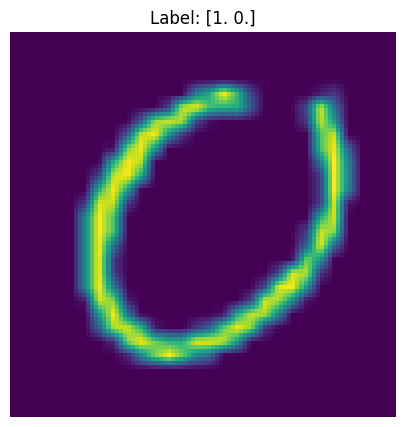

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of images and labels from the preprocessed dataset
images, labels = next(iter(train_batches))

# Function to display multiple images
def show_images(image_batch, label_batch, num_images=4):
    plt.figure(figsize=(10, 5))
    for n in range(num_images):
        ax = plt.subplot(1, num_images, n + 1)
        plt.imshow(image_batch[n])  # Rescale pixel values to [0, 1]
        plt.title(f"Label: {label_batch[n]}")
        plt.axis("off")

# Display the first 4 images in the batch
show_images(images.numpy(), labels.numpy(), num_images=1)

## My NET


In [ ]:
model = keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(96,96,1)),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=8, activation='relu'),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax),
])

model.summary()

# Compile the model
model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Train the model
EPOCHS = 2
model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=test_batches)

# Save the model to a file
tf.saved_model.save(model, "Model_tf_")

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 9216)              0         
                                                                 
 dense_15 (Dense)            (None, 32)                294944    
                                                                 
 dense_16 (Dense)            (None, 8)                 264       
                                                                 
 dense_17 (Dense)            (None, 2)                 18        
                                                                 
Total params: 295226 (1.13 MB)
Trainable params: 295226 (1.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
12665/12665 [==============================] - 69s 5ms/step - loss: 0.0174 - accuracy: 0.9966 - val_loss: 0.0014 - val_accuracy: 0.9991
Epoc

### Post-training quantization


In [ ]:
import tensorflow as tf
import numpy as np
import pathlib

# Load and convert exported model from file
converter = tf.lite.TFLiteConverter.from_saved_model("Model_tf_")
converter.optimizations = [tf.lite.Optimize.DEFAULT]

def representative_data_gen():
    for input_value, _ in test_batches.take(1000):
        yield [input_value]


converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model = converter.convert()

interpreter = tf.lite.Interpreter(model_content=tflite_model)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

tflite_model_file = pathlib.Path('Model_tf_3.tflite')
tflite_model_file.write_bytes(tflite_model)

# Set up input/output tensors
tflite_model_file = 'Model_tf_3.tflite'
interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()

# Set input values
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_index = input_details[0]["index"]
output_index = output_details[0]["index"]

# Run inference
score = 0
for img, label in test_batches.take(len(test_batches)):
    img_int8 = (img * 255 - 128).numpy().astype(np.int8) # Cuantizacion int8
    interpreter.set_tensor(input_index, img_int8)
    interpreter.invoke()

    prediction = np.argmax(interpreter.get_tensor(output_index))
    if prediction == np.argmax(label.numpy()):
        score = score + 1


input:  <class 'numpy.int8'>
output:  <class 'numpy.int8'>


In [ ]:
acc = score*100/len(test_batches)
print("Acuracy:",acc)

Acuracy: 99.57446808510639


In [ ]:
import os
#model size
def model_size(archivo1):
    tamano_archivo1 = os.path.getsize(archivo1)
    print(f"{archivo1} el tamaño es {tamano_archivo1}")

archivo = "/content/Model_tf_3.tflite"

model_size(archivo)

/content/Model_tf_3.tflite el tamaño es 150600


In [ ]:
!xxd -i Model_tf_3.tflite > converted_model_data.h

# Conclusion

Given the limited memory to store the weights of the model, it was chosen to build a simple and small neural network, obtaining a decent accuracy with which to work.

Convolutional networks seem to have compatibility problems in TensorFlow and TensorFlow Lite Micro. Some operations or dimensions are not compatible, which generates errors that cause the microcontroller to crash.

It is important to note that the Arduino BLE has 1MB of memory, which does not allow it to perform many operations. For this reason, it is essential to have a small model and few global variables so that the camera model can be processed in real time